In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import Data, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP, TrainRNN
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion

In [2]:
root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

### MLP: sanity check

In [3]:
net = MLP([784, 300, 10])
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = Data(train_set)

trainer = TrainMLP(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 7s) 0.0564 
62 1% (0m 8s) 0.0293 
93 2% (0m 8s) 0.0197 
124 3% (0m 8s) 0.0177 
155 4% (0m 9s) 0.0147 
186 5% (0m 9s) 0.0141 
217 6% (0m 9s) 0.0137 
248 7% (0m 10s) 0.0132 
279 8% (0m 10s) 0.0150 
310 9% (0m 11s) 0.0133 
341 10% (0m 11s) 0.0128 
372 11% (0m 11s) 0.0131 
403 12% (0m 12s) 0.0122 
434 13% (0m 12s) 0.0125 
465 14% (0m 12s) 0.0115 
496 15% (0m 12s) 0.0099 
527 16% (0m 13s) 0.0116 
558 17% (0m 13s) 0.0101 
589 18% (0m 13s) 0.0097 
620 19% (0m 14s) 0.0112 
651 20% (0m 14s) 0.0081 
682 21% (0m 14s) 0.0078 
713 22% (0m 15s) 0.0085 
744 23% (0m 15s) 0.0096 
775 24% (0m 16s) 0.0090 
806 25% (0m 16s) 0.0100 
837 26% (0m 16s) 0.0085 
868 27% (0m 16s) 0.0090 
899 28% (0m 17s) 0.0091 
930 29% (0m 17s) 0.0086 
961 30% (0m 17s) 0.0088 
992 31% (0m 18s) 0.0075 
1023 32% (0m 18s) 0.0074 
1054 33% (0m 18s) 0.0082 
1085 34% (0m 19s) 0.0081 
1116 35% (0m 19s) 0.0074 
1147 36% (0m 19s) 0.0072 
1178 37% (0m 20s) 0.0078 
1209 38% (0m 20s) 0.0059 
1240 39% (0m 20s) 0.0075 
1271 40% (0m

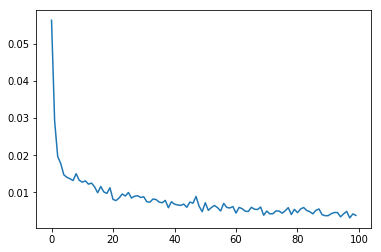

In [4]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 96.01%


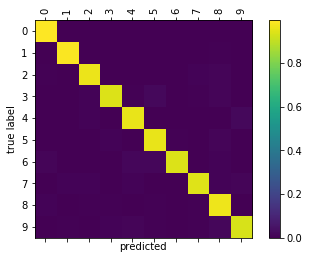

In [5]:
n_categories = 10
evaluation = Evaluation(net, Data(test_set))
confusion = evaluation.confusion(n_categories, n_confusion=10000)
plot_confusion(confusion)

# Sequence task: 1-3 mnist digits addition mod 10 (one output for seq)

In [3]:
# sample n_samples correctly classified examples
def getCorrect(net, data, n_samples=100):
    xs = []
    ys = []

    i = 0
    while i < n_samples:
        d = data.random_batch(batch_size=1)
        x, y = d[0], d[1]
        output = net.eval_forward(*d)
        _, ans = torch.max(output, 1)
        if ans.item() != y.item(): # incorrect
            continue

        xs.append(x)
        ys.append(y)
        i += 1
    return xs, ys

def show_examples(net, xs, ys, n_show=3):
    for x, y in zip(xs[:n_show], ys[:n_show]):
        yhat = net.eval_forward(x, y, [len(x)])
        val, ind = torch.max(yhat, 1)
        
        n_images, _, w_h = x.shape
        print('label: %d, predict: %d, prob: %.2f' % (y.item(), ind.item(), np.exp(val.item())))
        for i in range(n_images):
            plt.subplot(1,3,i+1)
            plt.imshow(x[i].view(28,28).detach().numpy())
        plt.show()

### 2 layer MLP on the last step

In [80]:
from lib.model import RNN_MLP

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set, min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0719 
62 1% (0m 2s) 0.0694 
93 2% (0m 3s) 0.0684 
124 3% (0m 4s) 0.0679 
155 4% (0m 5s) 0.0675 
186 5% (0m 6s) 0.0675 
217 6% (0m 7s) 0.0677 
248 7% (0m 9s) 0.0671 
279 8% (0m 10s) 0.0668 
310 9% (0m 11s) 0.0652 
341 10% (0m 12s) 0.0659 
372 11% (0m 13s) 0.0676 
403 12% (0m 14s) 0.0658 
434 13% (0m 16s) 0.0670 
465 14% (0m 17s) 0.0663 
496 15% (0m 18s) 0.0670 
527 16% (0m 19s) 0.0667 
558 17% (0m 21s) 0.0657 
589 18% (0m 22s) 0.0656 
620 19% (0m 23s) 0.0676 
651 20% (0m 24s) 0.0668 
682 21% (0m 25s) 0.0661 
713 22% (0m 27s) 0.0653 
744 23% (0m 28s) 0.0656 
775 24% (0m 29s) 0.0658 
806 25% (0m 30s) 0.0669 
837 26% (0m 31s) 0.0663 
868 27% (0m 32s) 0.0654 
899 28% (0m 34s) 0.0658 
930 29% (0m 35s) 0.0655 
961 30% (0m 36s) 0.0660 
992 31% (0m 37s) 0.0658 
1023 32% (0m 38s) 0.0651 
1054 33% (0m 39s) 0.0656 
1085 34% (0m 41s) 0.0673 
1116 35% (0m 42s) 0.0657 
1147 36% (0m 43s) 0.0652 
1178 37% (0m 44s) 0.0661 
1209 38% (0m 45s) 0.0661 
1240 39% (0m 46s) 0.0642 
1271 40% (0m 

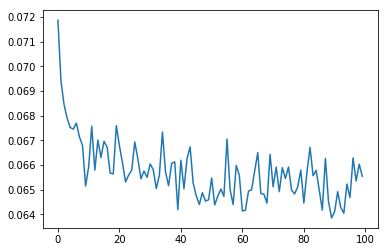

In [81]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 89.00%


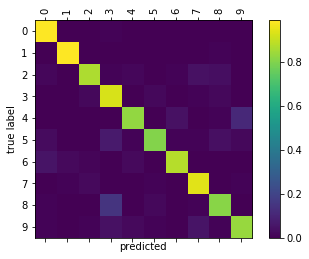

In [82]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Independent LSTM (each time step uses an independent LSTM cell)

In [58]:
from lib.model import RNN_ILSTM

n_hidden = 300
n_categories = 10
net = RNN_ILSTM(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 2s) 0.0719 
62 1% (0m 4s) 0.0715 
93 2% (0m 6s) 0.0710 
124 3% (0m 9s) 0.0709 
155 4% (0m 11s) 0.0704 
186 5% (0m 13s) 0.0700 
217 6% (0m 15s) 0.0696 
248 7% (0m 18s) 0.0693 
279 8% (0m 20s) 0.0692 
310 9% (0m 23s) 0.0685 
341 10% (0m 25s) 0.0687 
372 11% (0m 27s) 0.0682 
403 12% (0m 29s) 0.0685 
434 13% (0m 31s) 0.0674 
465 14% (0m 33s) 0.0672 
496 15% (0m 36s) 0.0670 
527 16% (0m 38s) 0.0668 
558 17% (0m 40s) 0.0671 
589 18% (0m 42s) 0.0668 
620 19% (0m 44s) 0.0656 
651 20% (0m 46s) 0.0655 
682 21% (0m 49s) 0.0655 
713 22% (0m 51s) 0.0656 
744 23% (0m 53s) 0.0650 
775 24% (0m 55s) 0.0656 
806 25% (0m 57s) 0.0652 
837 26% (0m 59s) 0.0648 
868 27% (1m 1s) 0.0660 
899 28% (1m 3s) 0.0646 
930 29% (1m 6s) 0.0657 
961 30% (1m 9s) 0.0637 
992 31% (1m 11s) 0.0648 
1023 32% (1m 13s) 0.0646 
1054 33% (1m 15s) 0.0633 
1085 34% (1m 17s) 0.0636 
1116 35% (1m 19s) 0.0636 
1147 36% (1m 21s) 0.0637 
1178 37% (1m 24s) 0.0624 
1209 38% (1m 26s) 0.0634 
1240 39% (1m 28s) 0.0642 
1271 40% (1m 

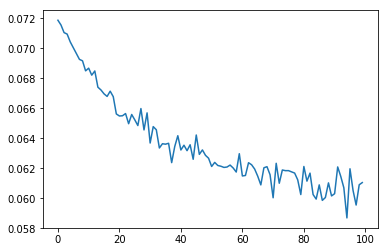

In [59]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 83.60%


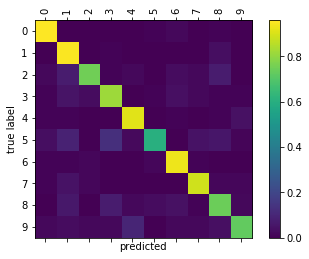

In [62]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Staged LSTM

In [63]:
from lib.model import RNN_SLSTM
n_hidden = 300
n_categories = 10
net = RNN_SLSTM(784, n_hidden, n_categories)
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 2s) 0.0716 
62 1% (0m 5s) 0.0679 
93 2% (0m 7s) 0.0656 
124 3% (0m 9s) 0.0622 
155 4% (0m 12s) 0.0561 
186 5% (0m 14s) 0.0545 
217 6% (0m 17s) 0.0537 
248 7% (0m 20s) 0.0534 
279 8% (0m 22s) 0.0509 
310 9% (0m 25s) 0.0510 
341 10% (0m 28s) 0.0492 
372 11% (0m 30s) 0.0500 
403 12% (0m 33s) 0.0486 
434 13% (0m 35s) 0.0470 
465 14% (0m 37s) 0.0498 
496 15% (0m 40s) 0.0466 
527 16% (0m 43s) 0.0460 
558 17% (0m 45s) 0.0475 
589 18% (0m 47s) 0.0466 
620 19% (0m 50s) 0.0486 
651 20% (0m 51s) 0.0434 
682 21% (0m 53s) 0.0455 
713 22% (0m 55s) 0.0462 
744 23% (0m 58s) 0.0441 
775 24% (1m 1s) 0.0410 
806 25% (1m 4s) 0.0444 
837 26% (1m 6s) 0.0427 
868 27% (1m 9s) 0.0415 
899 28% (1m 11s) 0.0418 
930 29% (1m 14s) 0.0429 
961 30% (1m 16s) 0.0417 
992 31% (1m 19s) 0.0398 
1023 32% (1m 21s) 0.0397 
1054 33% (1m 24s) 0.0397 
1085 34% (1m 26s) 0.0413 
1116 35% (1m 29s) 0.0413 
1147 36% (1m 31s) 0.0397 
1178 37% (1m 33s) 0.0396 
1209 38% (1m 35s) 0.0404 
1240 39% (1m 38s) 0.0387 
1271 40% (1m 

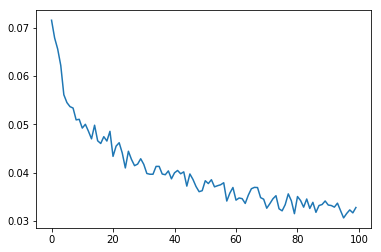

In [64]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 23.80%


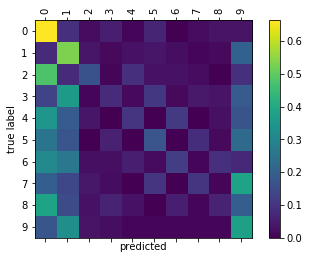

In [67]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=3, max_length=3))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### LSTM

In [7]:
n_hidden = 300
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0716 
62 1% (0m 2s) 0.0696 
93 2% (0m 4s) 0.0669 
124 3% (0m 6s) 0.0621 
155 4% (0m 8s) 0.0581 
186 5% (0m 11s) 0.0555 
217 6% (0m 15s) 0.0527 
248 7% (0m 19s) 0.0519 
279 8% (0m 21s) 0.0503 
310 9% (0m 24s) 0.0500 
341 10% (0m 27s) 0.0508 
372 11% (0m 31s) 0.0490 
403 12% (0m 34s) 0.0482 
434 13% (0m 39s) 0.0459 
465 14% (0m 43s) 0.0474 
496 15% (0m 47s) 0.0468 
527 16% (0m 50s) 0.0454 
558 17% (0m 53s) 0.0464 
589 18% (0m 58s) 0.0445 
620 19% (1m 2s) 0.0446 
651 20% (1m 6s) 0.0431 
682 21% (1m 10s) 0.0433 
713 22% (1m 14s) 0.0443 
744 23% (1m 18s) 0.0430 
775 24% (1m 20s) 0.0431 
806 25% (1m 25s) 0.0417 
837 26% (1m 29s) 0.0394 
868 27% (1m 33s) 0.0410 
899 28% (1m 36s) 0.0410 
930 29% (1m 38s) 0.0407 
961 30% (1m 42s) 0.0381 
992 31% (1m 47s) 0.0399 
1023 32% (1m 50s) 0.0384 
1054 33% (1m 53s) 0.0384 
1085 34% (1m 57s) 0.0392 
1116 35% (1m 58s) 0.0356 
1147 36% (2m 2s) 0.0346 
1178 37% (2m 5s) 0.0397 
1209 38% (2m 11s) 0.0344 
1240 39% (2m 17s) 0.0342 
1271 40% (2m 2

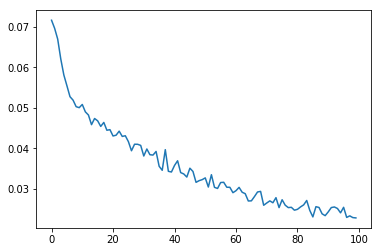

In [8]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 93.70%


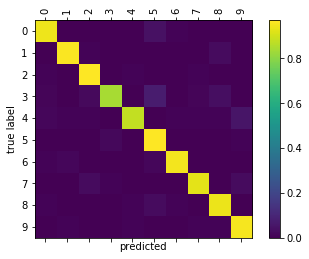

In [14]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

label: 9, predict: 9, prob: 0.70


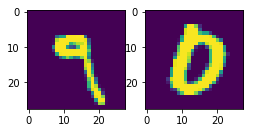

label: 6, predict: 6, prob: 0.44


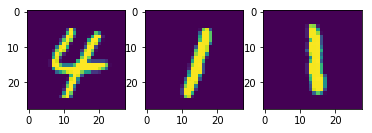

label: 8, predict: 8, prob: 0.23


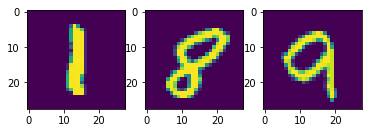

In [27]:
xs, ys = getCorrect(net, MNIST_add_data(test_set, min_length=2, max_length=3))    
show_examples(net, xs, ys)

# Q3 MTL matrix factorization method with learnable gates (deprecated; as reference to how to implement hypernetwork)

In [827]:
# overload '+' sign to have two tasks and still train for the rnn class
net_res = RNN_LSTM(784, n_hidden, n_categories)
n_basis = 2
params = []

coef = torch.nn.Parameter(torch.zeros(n_basis))
nn.init.uniform_(coef)
net_res.coef = coef

for n, p in net_res.named_parameters():
    if 'bias' not in n and 'coef' not in n:
        for _ in range(n_basis):
            theta = torch.nn.Parameter(p.data / n_basis)
            params.append(theta)
    else:
        params.append(p)

net_res.forward_ready = False
net_res.params = params
net_res.n_basis = n_basis

def forward_function(x_list, coef):
    res = 0
    for i in range(len(x_list)):
        res += x_list[i] * coef[i]
    return res
    
def prepare_forward(self, x_not_used):
    
    if hasattr(self, 'forward_ready') and self.forward_ready:
        return 
    
    i = 0
    for n, p in self.named_parameters():
        if 'bias' not in n and 'coef' not in n:
            p.data = forward_function(self.params[i:i+self.n_basis], self.coef)
            i += self.n_basis
        else:
            i += 1
    self.forward_ready = True

def after_backward(self):
    # bug report: in register_backward_hook, backward failed!!! need to explicitly do it as shown in train_rnn_reg2 below
    i = 0
    for n, p in self.named_parameters():
        if 'bias' not in n and 'coef' not in n:
            c = forward_function(self.params[i:i+n_basis], self.coef)
            if p.grad is not None:
                c.backward(p.grad)
                p.grad.zero_() # zero out parameter grad
            i += self.n_basis
        else:
            i += 1
    self.forward_ready = False

def train_rnn_reg2(net, optimizer, criterion, x, y, x_lengths):
    optimizer.zero_grad()

    loss = criterion(net, x, y, x_lengths)
    loss.backward()
    after_backward(net)

    optimizer.step()

    return output, loss.item()

def l0(loss, alpha):
    
    def reg(x):
        return 0.5 * x.dot(x)
    
    def ret(net, x, y, x_lengths):
        x.requires_grad = True
        yhat = evaluateBatch(net, x, x_lengths)
        l = loss(yhat, y)
        return l
    
    return ret

#print([x.shape for x in params])
print(net_res.coef)

Parameter containing:
tensor([0.1168, 0.7817], requires_grad=True)
